In [1]:
# 0. 라이브러리 및 환경 설정
import pandas as pd
import numpy as np
import re, copy
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from kiwipiepy import Kiwi
from kiwipiepy.utils import Stopwords

plt.rc('font', family='Malgun Gothic')  # 폰트 설정
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# wordcloud에서 한글을 사용할 수 있도록 설정하기
font_path = 'C:\\Users\\user\\anaconda3\\envs\\kiwi\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\malgun.ttf'

In [3]:
data = pd.read_csv('data/Merged_에어서울.csv')

In [4]:
print(f'전처리 전 학습용 샘플의 개수 : {len(data)}')

# document 열에서 중복인 내용이 있다면 중복 제거(재확인)
data.drop_duplicates(subset = ['review'], inplace=True)

# 한국어가 하나도 없는 리뷰 없애기
data = data[data['review'].apply(lambda x: bool(re.search('[가-힣]', str(x))))]

# 공백은 empty 값으로 변경
data['review'] = data['review'].str.replace('^ +', "")

# document column이 비어있다면(공백), Null 값으로 변경
data['review'].replace('', np.nan, inplace=True)

# Null 값 제거
data = data.dropna(how='any')

# index reset
data = data.reset_index(drop=True)
print(f'전처리 후 학습용 샘플의 개수 : {len(data)}')

전처리 전 학습용 샘플의 개수 : 1233
전처리 후 학습용 샘플의 개수 : 1226


In [5]:
kiwi = Kiwi(typos='basic')
stopwords = Stopwords()

In [6]:
def preprocess_korean(text, analyzer=kiwi, stopwords=stopwords):
    my_text = copy.copy(text)
    my_text = my_text.replace('\n', ' ') # (1) 줄바꿈 문자 제거
    my_text = kiwi.space(my_text) # (2) 띄어쓰기 교정
    sents = kiwi.split_into_sents(my_text) # (3) 문장 토큰화
    p = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]')
    all_result = []
    for sent in sents:
        token_result = kiwi.tokenize(sent.text, stopwords=stopwords) # (4) 형태소 분석 + 간단한 오타 교정
        token_result = kiwi.join(token_result)
        token_result = p.sub('', token_result) # (5) 특수 문자 제거 (=한글을 제외한 문자 제거)
        all_result.append(token_result) # (6) 형태소 분석한 결과를 다시 join
    
    all_result = ' '.join(all_result) # (7) 모든 문장을 하나의 string으로 join

    return all_result

In [7]:
# 전처리 수행한 새로운 컬럼 추가
data['preprocessed_review'] = data['review'].apply(lambda x: preprocess_korean(x))

In [8]:
# wordcloud를 생성하기 위해 전처리된 text들을 하나의 큰 text로 결합
all_data = ''
for _, row in data.iterrows():
    all_data += row['preprocessed_review']

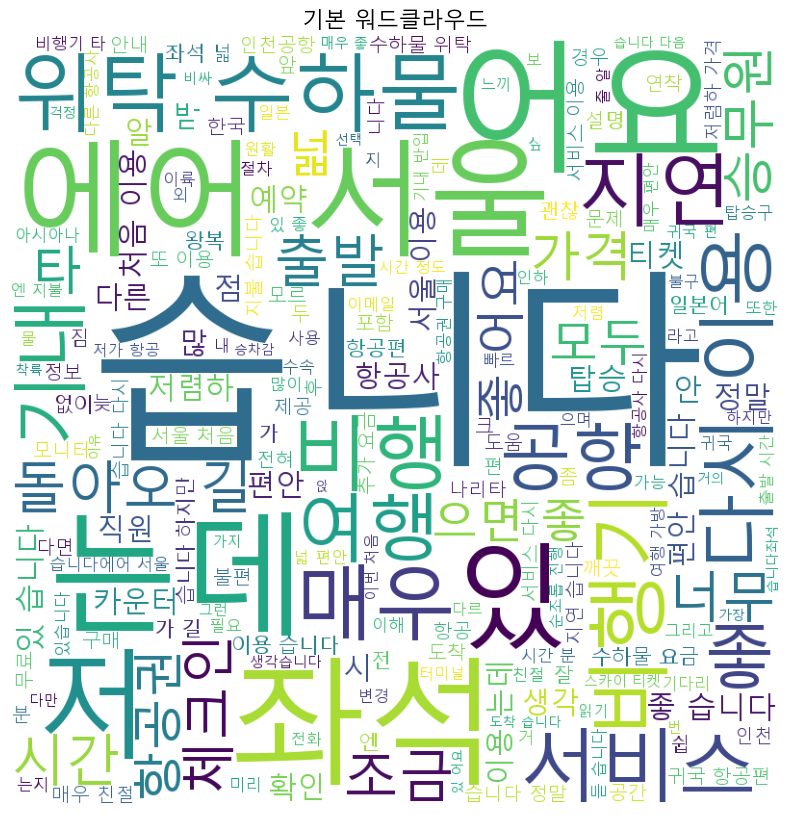

In [9]:
# (1) WordCloud 객체를 생성하고, 워드 클라우드 만들기
cloud = WordCloud(font_path=font_path,
                  background_color = 'white', 
                  width=800, height=800)
my_cloud1 = cloud.generate_from_text(all_data)

# (2) numpy array형태로 바꿔주기
arr1 = my_cloud1.to_array()

# (3) 그림 그리기
fig = plt.figure(figsize=(10, 10))
plt.imshow(arr1)
plt.axis('off')
plt.title("기본 워드클라우드", fontsize=16)
plt.show()

# 형용사만 포함하여 수행

In [10]:
def preprocess_adjectives_only(text, analyzer=kiwi, stopwords=stopwords):
    my_text = copy.copy(text)
    my_text = my_text.replace('\n', ' ')  # (1) 줄바꿈 제거
    my_text = kiwi.space(my_text)        # (2) 띄어쓰기 교정
    sents = kiwi.split_into_sents(my_text)  # (3) 문장 토큰화
    p = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]')  # (5) 특수문자 제거용 정규식
    all_result = []

    for sent in sents:
        token_result = kiwi.tokenize(sent.text, stopwords=stopwords)  # (4) 형태소 분석
        adj_list = []
        for i in token_result:
            # 형용사만 포함
            if 'VA' in i.tag:
                adj_list.append(f'{i.form}다')
        joined = ' '.join(adj_list)
        joined = p.sub('', joined)
        all_result.append(joined)

    return ' '.join(all_result)  # 최종 문자열로 반환

In [11]:
data['adjectives_review'] = data['review'].apply(lambda x: preprocess_adjectives_only(x))

In [12]:
# wordcloud를 생성하기 위해 전처리된 text들을 하나의 큰 text로 결합
adj_data = ''
for _, row in data.iterrows():
    adj_data += row['adjectives_review']

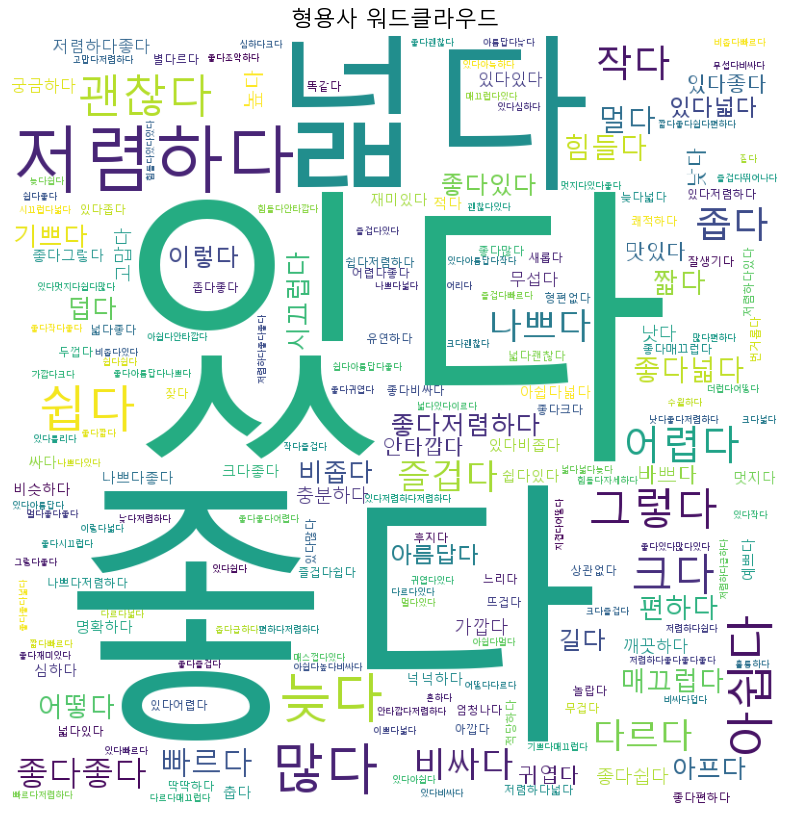

In [13]:
# (1) WordCloud 객체를 생성하고, 워드 클라우드 만들기
cloud = WordCloud(font_path=font_path,
                  background_color = 'white', 
                  width=800, height=800)
my_cloud1 = cloud.generate_from_text(adj_data)

# (2) numpy array형태로 바꿔주기
arr1 = my_cloud1.to_array()

# (3) 그림 그리기
fig = plt.figure(figsize=(10, 10))
plt.imshow(arr1)
plt.axis('off')
plt.title("형용사 워드클라우드", fontsize=16)
plt.show()

# 두 가지 noise(있다, 좋다) 제외하여 수행

In [14]:
def preprocess_adjectives_only(text, analyzer=kiwi, stopwords=stopwords):
    my_text = copy.copy(text)
    my_text = kiwi.space(my_text.replace('\n', ' '))  # 줄바꿈 제거 + 띄어쓰기 교정
    sents = kiwi.split_into_sents(my_text)  # 문장 토큰화
    p = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]')  # 특수문자 제거용 정규식
    all_result = []

    for sent in sents:
        token_result = kiwi.tokenize(sent.text, stopwords=stopwords)  # 형태소 분석
        adj_list = []
        for i in token_result:
            if 'VA' in i.tag:
                adj = f'{i.form}다'
                if adj not in ['있다', '좋다']:  # noise filtering
                    adj_list.append(adj)
        joined = ' '.join(adj_list)
        joined = p.sub('', joined)
        all_result.append(joined)

    return ' '.join(all_result)


In [15]:
data['adjectives_review'] = data['review'].apply(lambda x: preprocess_adjectives_only(x))

In [16]:
# wordcloud를 생성하기 위해 전처리된 text들을 하나의 큰 text로 결합
adj_data = ''
for _, row in data.iterrows():
    adj_data += row['adjectives_review']

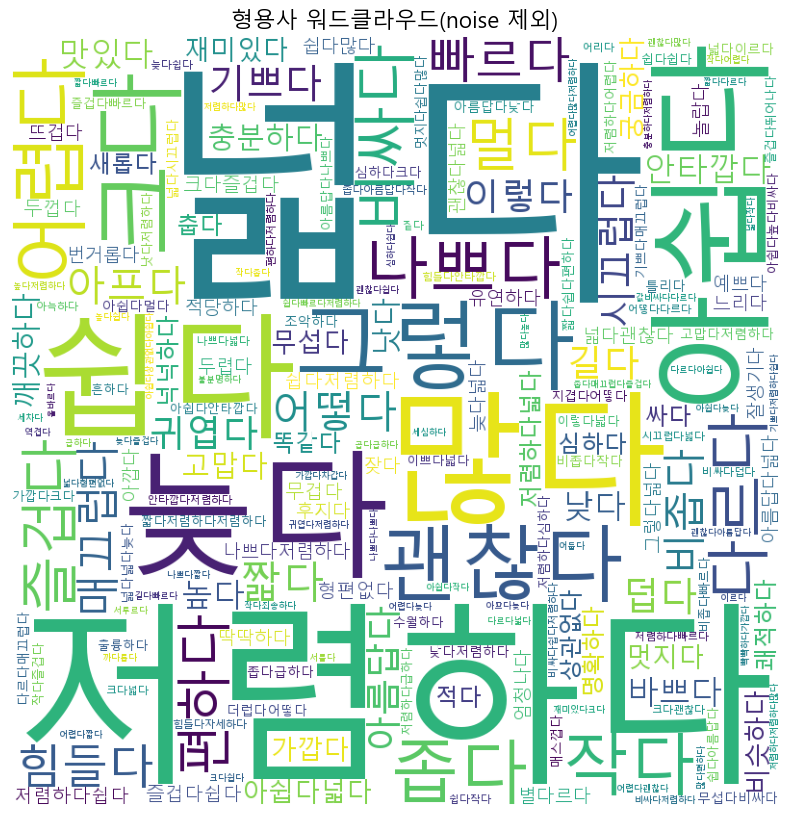

In [17]:
# (1) WordCloud 객체를 생성하고, 워드 클라우드 만들기
cloud = WordCloud(font_path=font_path,
                  background_color = 'white', 
                  width=800, height=800)
my_cloud1 = cloud.generate_from_text(adj_data)

# (2) numpy array형태로 바꿔주기
arr1 = my_cloud1.to_array()

# (3) 그림 그리기
fig = plt.figure(figsize=(10, 10))
plt.imshow(arr1)
plt.axis('off')
plt.title("형용사 워드클라우드(noise 제외)", fontsize=16)
plt.show()

# 단어 조합(명사 + 형용사)으로 수행

In [18]:
def preprocess_noun_adj_pairs(text, analyzer=kiwi, stopwords=stopwords):
    my_text = copy.copy(text)
    my_text = my_text.replace('\n', ' ')  # (1) 줄바꿈 제거
    my_text = kiwi.space(my_text)        # (2) 띄어쓰기 교정
    sents = kiwi.split_into_sents(my_text)  # (3) 문장 토큰화
    p = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣_]')  # (5) 특수문자 제거 (_는 유지해야 함)
    all_result = []

    for sent in sents:
        token_result = kiwi.tokenize(sent.text, stopwords=stopwords)  # (4) 형태소 분석
        last_noun = None
        pair_list = []

        for token in token_result:
            if token.tag.startswith('NN'):  # 일반 명사
                last_noun = token.form
            elif token.tag.startswith('VA') and last_noun:  # 형용사 + 이전 명사 있으면
                pair = f'{last_noun}_{token.form}다'
                pair = p.sub('', pair)
                pair_list.append(pair)
                last_noun = None  # 한 번 연결했으면 초기화

        all_result.extend(pair_list)

    return ' '.join(all_result)


In [19]:
data['noun_adj_review'] = data['review'].apply(lambda x: preprocess_noun_adj_pairs(x))

In [20]:
# wordcloud를 생성하기 위해 전처리된 text들을 하나의 큰 text로 결합
pair_data = ''
for _, row in data.iterrows():
    pair_data += row['noun_adj_review']

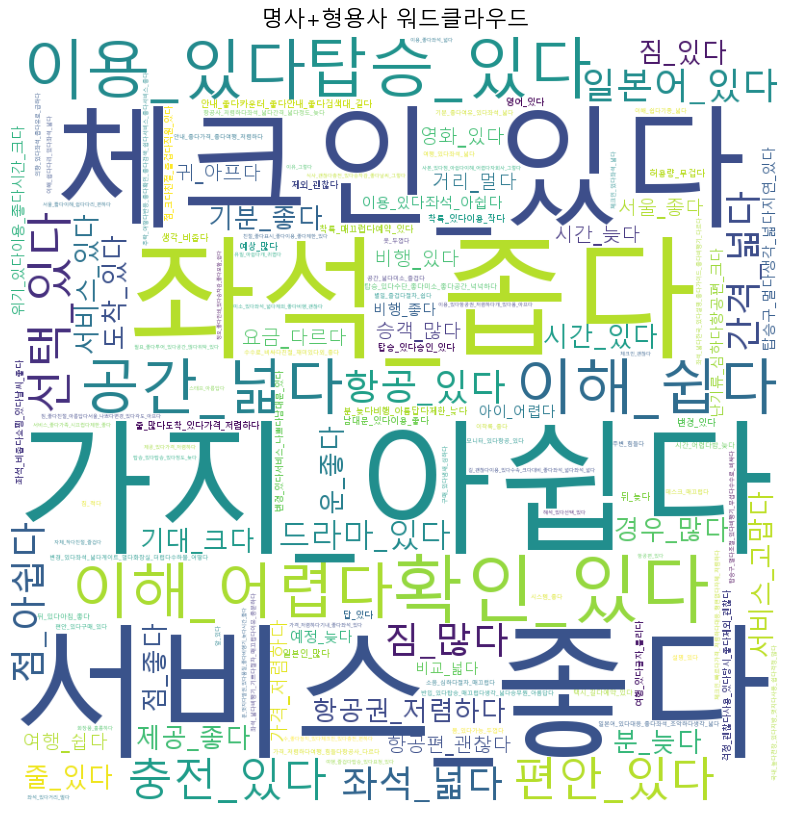

In [26]:
# (1) WordCloud 객체를 생성하고, 워드 클라우드 만들기
cloud = WordCloud(font_path=font_path,
                  background_color = 'white', 
                  width=800, height=800)
my_cloud1 = cloud.generate_from_text(pair_data)

# (2) numpy array형태로 바꿔주기
arr1 = my_cloud1.to_array()

# (3) 그림 그리기
fig = plt.figure(figsize=(10, 10))
plt.imshow(arr1)
plt.axis('off')
plt.title("명사+형용사 워드클라우드", fontsize=16)
plt.show()